<a href="https://colab.research.google.com/github/PradiptaBehera8558/B.Tech-Major-Project-2019-2023/blob/main/SOLANA_SOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 17.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats.mstats import winsorize
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron as ppca
from tabulate import tabulate
from arch import arch_model
import arch
from ta import trend
from ta import volatility
import matplotlib.pyplot as plt

In [6]:
data = pd.read_excel('gdrive/MyDrive/project/Major Project/Final Data Set/SOLANA SOL.xlsx')
data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2023-02-15,21.82,23.90,21.50,23.88,747616299,8990838024
1,2023-02-14,20.78,22.25,20.71,21.82,865868623,8215786249
2,2023-02-13,21.49,21.53,19.87,20.79,693292656,7805456771
3,2023-02-12,20.83,22.26,20.65,21.49,532943787,8065341451
4,2023-02-11,20.13,20.86,20.12,20.83,267159267,7816989405


In [7]:
col_name = ['Date','Open','High','Low','Close','Volume','MarketCapita']
data.columns = col_name
def clean_columns(col):
    col = col.astype(str)
    if col.name.lower().startswith('date'):
        return pd.to_datetime(col)
    return pd.to_numeric(col.str.replace(',', '').str.replace('$', ''), errors='coerce')
data = data.apply(clean_columns)
data = data.set_index('Date')

<ipython-input-7-a91d3682f4c5>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  return pd.to_numeric(col.str.replace(',', '').str.replace('$', ''), errors='coerce')


In [8]:
data['Daily_Return'] = data['Close'].pct_change()
data['Daily_Volumetric_Change'] = data['Volume'].pct_change()
data = data.iloc[1:]

In [9]:
print("Shape of the Collected Solana Data : {}".format(data.shape))

Shape of the Collected Solana Data : (1041, 8)


In [10]:
print("Datatypes of all the available columns in the dataset :\n{}".format(data.dtypes))

Datatypes of all the available columns in the dataset :
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                       int64
MarketCapita                 int64
Daily_Return               float64
Daily_Volumetric_Change    float64
dtype: object


In [11]:
print("Count of null values present in all the available columns in the dataset :\n{}".format(data.isnull().sum()))

Count of null values present in all the available columns in the dataset :
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
MarketCapita               0
Daily_Return               0
Daily_Volumetric_Change    0
dtype: int64


In [12]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1
outliers = (data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))
outlier_rows = np.where(outliers.any(axis=1))[0]
print("No. of outlying rows present in the dataset : {}".format(len(outlier_rows)))

No. of outlying rows present in the dataset : 168


In [13]:
iqr = data.quantile(0.75) - data.quantile(0.25)
print("Descriptive Statistics of the Dataset is given below: ")
stats = pd.concat([data.describe().T,
                data.mad().to_frame('MAD'),
                data.skew().to_frame('Skew'),
                data.kurtosis().to_frame('Kurtosis'),
                data.sem().to_frame('SEM'),
                iqr.to_frame('IQR'),
                data.var().to_frame('Variance')
            ],
              axis=1)
stats.to_excel("sol-stats.xlsx")

Descriptive Statistics of the Dataset is given below: 


In [14]:
diff=data.index.to_series().diff().dt.days
#Check for gaps in the data
if(diff>1).any():
  print("There are gaps in the data")
else:
  print("The data is continuous")

The data is continuous


In [15]:
alpha = 0.05
close_price_test = adfuller(data['Daily_Return'], autolag='AIC')

print("============================================================================================")
print('ADF Statistic: %f' % close_price_test[0])
print('p-value: %f' % close_price_test[1])
print('Critical Values:')
for key, value in close_price_test[4].items():
    print('\t%s: %.3f' % (key, value))

if close_price_test[1] < alpha:
    close_price_trend = "Stationary"
    print("The trend is {} for Daily Returns".format(close_price_trend))
    print("============================================================================================")
else:
    close_price_test = ppca(np.array(data['Daily_Return']),autolag='AIC')
    print("============================================================================================")
    print('PP Statistic: %f' % close_price_test[0])
    print('p-value: %f' % close_price_test[1])
    print('Critical Values:')
    for key, value in close_price_test[3].items():
        print('\t%s: %.3f' % (key, value))
    if close_price_test[1] < alpha:
        close_price_trend = "Stationary"
        print("The trend is {} for Daily Returns".format(close_price_trend))
        print("============================================================================================")
    else:
        close_price_trend = "Trend"
        print("The trend is {} for Daily Returns".format(close_price_trend))
        print("============================================================================================")

# Test for trend in volume
volume_test = adfuller(data['Daily_Volumetric_Change'], autolag='AIC')

print("============================================================================================")
print('ADF Statistic: %f' % volume_test[0])
print('p-value: %f' % volume_test[1])
print('Critical Values:')
for key, value in volume_test[4].items():
    print('\t%s: %.3f' % (key, value))

if volume_test[1] < alpha:
    volume_trend = "Stationary"
    print("The trend is {} for Daily Volumetric Change".format(volume_trend))
    print("============================================================================================")
else:
    volume_test = ppca(np.array(data['Daily_Volumetric_Change']), autolag='AIC')
    print("============================================================================================")
    print('PP Statistic: %f' % volume_test[0])
    print('p-value: %f' % volume_test[1])
    print('Critical Values:')
    for key, value in volume_test[3].items():
        print('\t%s: %.3f' % (key, value))
        
    if volume_test[1] < alpha:
        volume_trend = "Stationary"
        print("The trend is {} for Daily Volumetric Change".format(volume_trend))
        print("============================================================================================")
    else:
        volume_trend = "Trend"
        print("The trend is {} for Daily Volumetric Change".format(volume_trend))

ADF Statistic: -34.006912
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
The trend is Stationary for Daily Returns
ADF Statistic: -7.566991
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
The trend is Stationary for Daily Volumetric Change


In [16]:
"""
    -> Testing of volatility using GARCH Model    
"""
# Testing for volatility in volume change
garch_model1 = arch.arch_model(data['Daily_Volumetric_Change'], vol='GARCH', p=1, q=1)
garch_result1 = garch_model1.fit(disp='off')
# Extract volatility series
vol_volatility = garch_result1.conditional_volatility
volume_std = data['Daily_Volumetric_Change'].std()

# Testing for volatility in daily returns
garch_model2 = arch.arch_model(data['Daily_Return'], vol='GARCH', p=1, q=1)
garch_result2 = garch_model2.fit(disp='off')
# Extract volatility series
daily_returns_volatility = garch_result2.conditional_volatility
daily_returns_std = data['Daily_Return'].std()


# Set volatility threshold to 1.5 times standard deviation
volume_threshold = 1.5 * volume_std
if vol_volatility.max() > volume_threshold:
    print("============================================================================================")
    print('Volatility detected for Daily Volumetric Change')
    print("============================================================================================")
else:
    print("============================================================================================")
    print('No volatility detected for Daily Volumetric Change')
    print("============================================================================================")
    

daily_returns_threshold = 1.5 * daily_returns_std
if daily_returns_volatility.max() > daily_returns_threshold:
    print("============================================================================================")
    print('Volatility detected for Daily Returns')
    print("============================================================================================")
else:
    print("============================================================================================")
    print('No volatility detected for Daily Returns')
    print("============================================================================================")

Volatility detected for Daily Volumetric Change
Volatility detected for Daily Returns


/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006554. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [17]:
df = data.copy(deep=True)

================ Implementation of Moving Average Convergence Divergence (Trend Indicator) ================


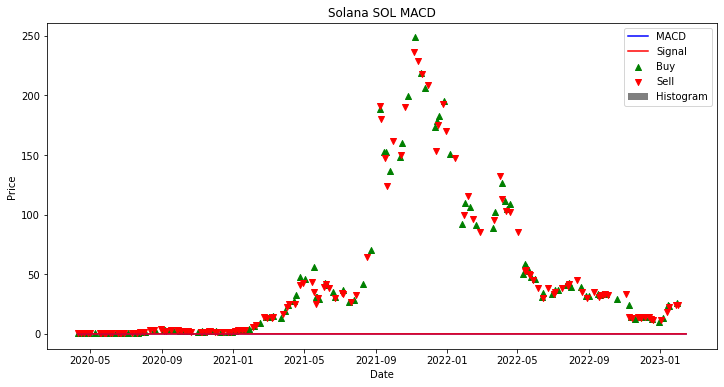

In [18]:
print("================ Implementation of Moving Average Convergence Divergence (Trend Indicator) ================")
fast_period = 12
slow_period = 26
signal_period = 9
ema_fast = df['Daily_Return'].ewm(span=fast_period, adjust=False).mean()
ema_slow = df['Daily_Return'].ewm(span=slow_period, adjust=False).mean()
macd = ema_fast - ema_slow
signal = macd.ewm(span=signal_period, adjust=False).mean()
hist = macd - signal

# Define buy and sell signals using if else conditional
df['Buy_Signal'] = np.where((macd > signal) & (macd.shift() < signal.shift()), 1, 0)
df['Sell_Signal'] = np.where((macd < signal) & (macd.shift() > signal.shift()), -1, 0)

# Plot MACD and buy/sell signals
plt.figure(figsize=(12,6))
plt.plot(df.index, macd, label='MACD', color='blue')
plt.plot(df.index, signal, label='Signal', color='red')
plt.bar(df.index, hist, label='Histogram', color='gray')
plt.scatter(df[df['Buy_Signal'] == 1].index, df[df['Buy_Signal'] == 1]['Close'], label='Buy', marker='^', color='green')
plt.scatter(df[df['Sell_Signal'] == -1].index, df[df['Sell_Signal'] == -1]['Close'], label='Sell', marker='v', color='red')
plt.legend()
plt.title('Solana SOL MACD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print("=============================================================================================================================")

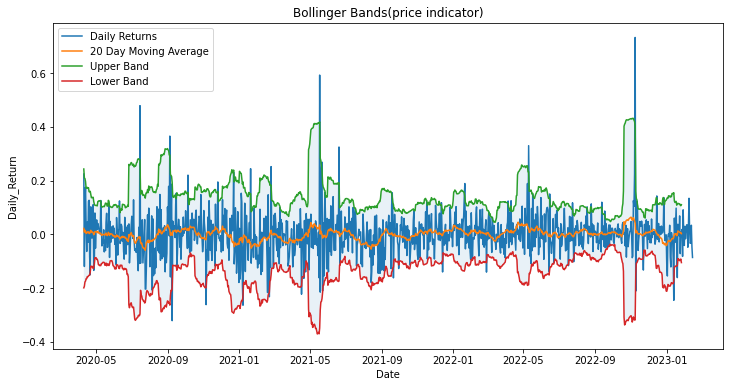

<ipython-input-19-c0451fba55a6>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'][i] = 1
<ipython-input-19-c0451fba55a6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'][i] = -1


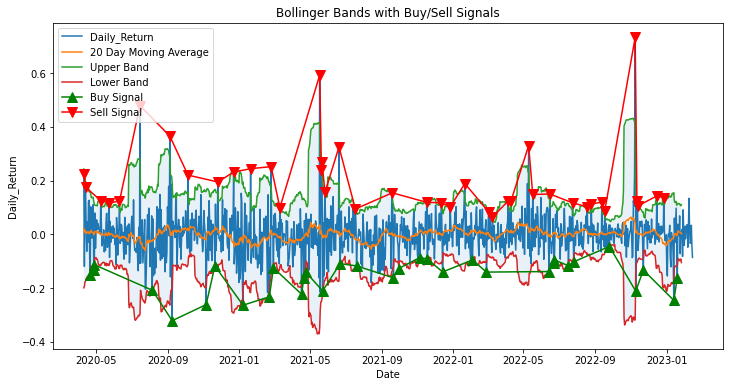

In [19]:
# Compute 20-day rolling mean and standard deviation
df['Close: 20 Day Mean'] = df['Daily_Return'].rolling(window=20).mean()
df['Close: 20 Day STD'] = df['Daily_Return'].rolling(window=20).std()

# Compute upper and lower Bollinger Bands
df['Upper Band'] = df['Close: 20 Day Mean'] + (df['Close: 20 Day STD'] * 2)
df['Lower Band'] = df['Close: 20 Day Mean'] - (df['Close: 20 Day STD'] * 2)

# Plot Bollinger Bands
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily_Return'], label='Daily Returns')
plt.plot(df.index, df['Close: 20 Day Mean'], label='20 Day Moving Average')
plt.plot(df.index, df['Upper Band'], label='Upper Band')
plt.plot(df.index, df['Lower Band'], label='Lower Band')
plt.fill_between(df.index, df['Lower Band'], df['Upper Band'], alpha=0.1)
plt.title('Bollinger Bands(price indicator)')
plt.xlabel('Date')
plt.ylabel('Daily_Return')
plt.legend()
plt.show()

# Generate buy and sell signals
df['Position'] = None

for i in range(20, len(df)):
    if df['Daily_Return'][i] > df['Upper Band'][i-1]: # Sell signal
        df['Position'][i] = -1
    elif df['Daily_Return'][i] < df['Lower Band'][i-1]: # Buy signal
        df['Position'][i] = 1
        
# Plot buy and sell signals
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily_Return'], label='Daily_Return')
plt.plot(df.index, df['Close: 20 Day Mean'], label='20 Day Moving Average')
plt.plot(df.index, df['Upper Band'], label='Upper Band')
plt.plot(df.index, df['Lower Band'], label='Lower Band')
plt.fill_between(df.index, df['Lower Band'], df['Upper Band'], alpha=0.1)

# Plot buy and sell signals
plt.plot(df[df['Position'] == 1].index, df[df['Position'] == 1]['Daily_Return'], marker='^', markersize=10, color='green', label='Buy Signal')
plt.plot(df[df['Position'] == -1].index, df[df['Position'] == -1]['Daily_Return'], marker='v', markersize=10, color='red', label='Sell Signal')

plt.title('Bollinger Bands with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Daily_Return')
plt.legend()
plt.show()

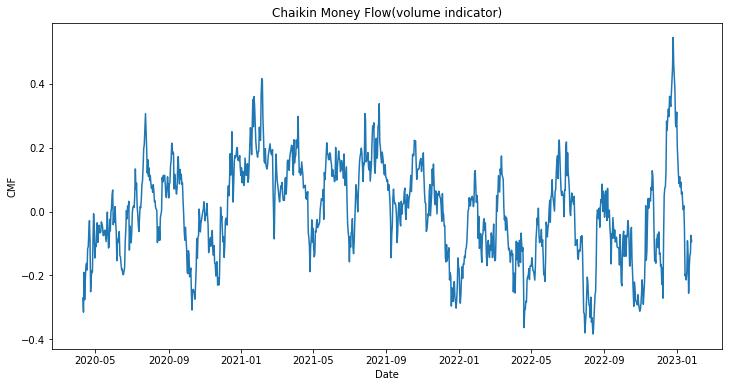

In [20]:
# Compute CMF
money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
money_flow_volume = money_flow_multiplier * df['Volume']
cmf = money_flow_volume.rolling(window=20).sum() / df['Volume'].rolling(window=20).sum()

# Plot CMF
plt.figure(figsize=(12,6))
plt.plot(df.index, cmf)
plt.title('Chaikin Money Flow(volume indicator)')
plt.xlabel('Date')
plt.ylabel('CMF')
plt.show()

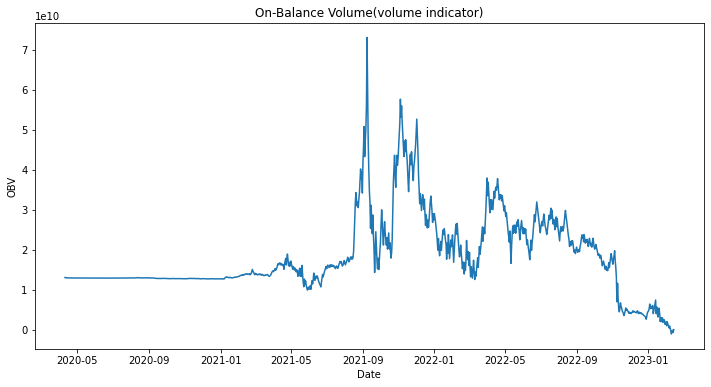

In [21]:
# Compute OBV
obv = pd.Series([0] * len(df))
for i in range(1, len(df)):
    if df['Close'][i] > df['Close'][i-1]:
        obv[i] = obv[i-1] + df['Volume'][i]
    elif df['Close'][i] < df['Close'][i-1]:
        obv[i] = obv[i-1] - df['Volume'][i]
    else:
        obv[i] = obv[i-1]

# Plot OBV
plt.figure(figsize=(12,6))
plt.plot(df.index, obv)
plt.title('On-Balance Volume(volume indicator)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.show()

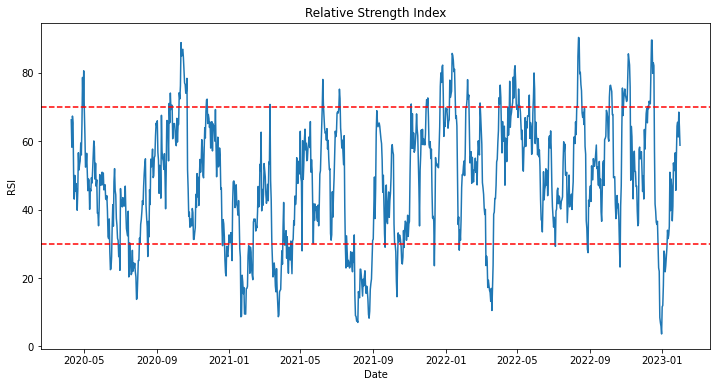

In [22]:
# Define RSI period and calculate change in price
rsi_period = 14
delta = df['Close'].diff()

# Get positive and negative price changes
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

# Calculate average gain and loss
avg_gain = up.rolling(window=rsi_period).mean()
avg_loss = abs(down.rolling(window=rsi_period).mean())

# Calculate RSI
rs = avg_gain / avg_loss
rsi = 100.0 - (100.0 / (1.0 + rs))

# Plot RSI
plt.figure(figsize=(12,6))
plt.plot(data.index, rsi)
plt.axhline(y=30, color='r', linestyle='--')
plt.axhline(y=70, color='r', linestyle='--')
plt.title('Relative Strength Index')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

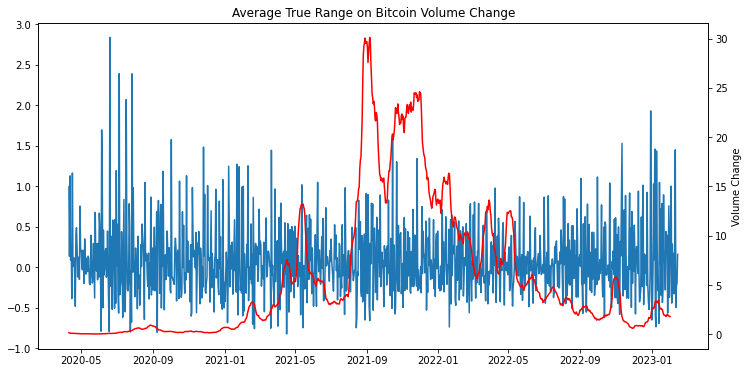

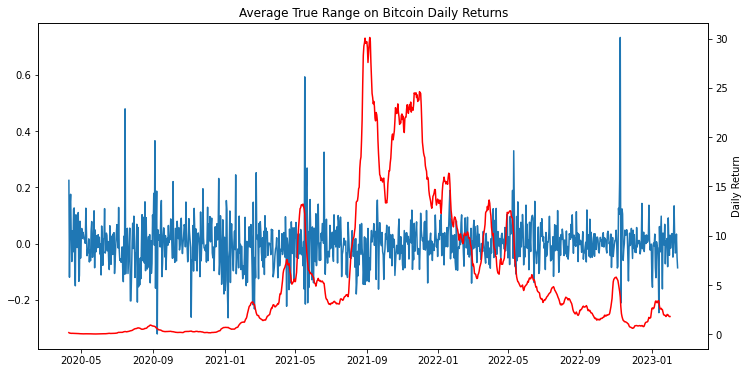

In [23]:
atr_period = 14

# Calculate True Range (TR)
df['High_Low'] = abs(df['High'] - df['Low'])
df['High_Close'] = abs(df['High'] - df['Close'].shift())
df['Low_Close'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculate Average True Range (ATR)
df['ATR'] = df['TR'].rolling(window=atr_period).mean()

# Plot ATR on Volume Change
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily_Volumetric_Change'])
plt.twinx()
plt.plot(df.index, df['ATR'], color='r')
plt.title('Average True Range on Bitcoin Volume Change')
plt.xlabel('Date')
plt.ylabel('Volume Change')
plt.show()
print("===================================================================================================")
# Plot ATR on Daily Returns
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily_Return'])
plt.twinx()
plt.plot(df.index, df['ATR'], color='r')
plt.title('Average True Range on Bitcoin Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

In [24]:
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

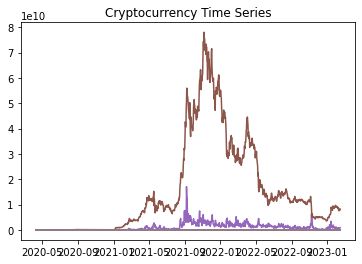

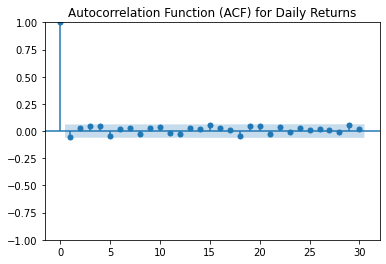

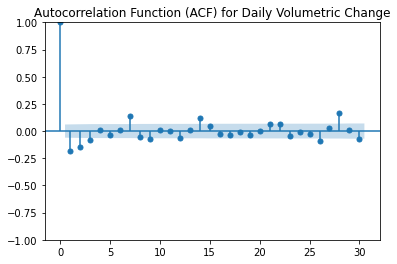

In [25]:
plt.plot(data)
plt.title('Cryptocurrency Time Series')
plt.show()
plot_acf(data['Daily_Return'], lags=30)
plt.title('Autocorrelation Function (ACF) for Daily Returns')
plt.show()
plot_acf(data['Daily_Volumetric_Change'], lags=30)
plt.title('Autocorrelation Function (ACF) for Daily Volumetric Change')
plt.show()

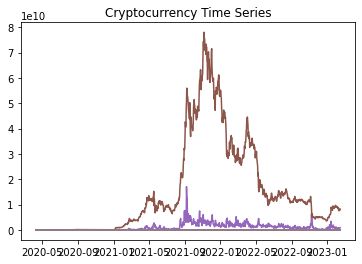

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


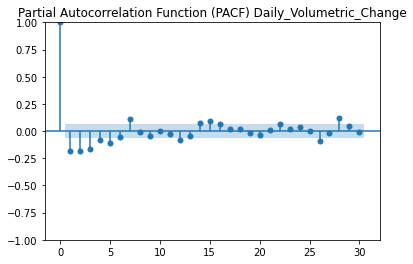

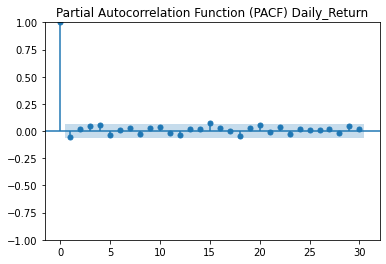

In [26]:
plt.plot(data)
plt.title('Cryptocurrency Time Series')
plt.show()
plot_pacf(data['Daily_Volumetric_Change'], lags=30)
plt.title('Partial Autocorrelation Function (PACF) Daily_Volumetric_Change')
plt.show()
plot_pacf(data['Daily_Return'], lags=30)
plt.title('Partial Autocorrelation Function (PACF) Daily_Return')
plt.show()

In [27]:
from scipy.stats.mstats import winsorize
cols_to_winsorize = data.columns
data[cols_to_winsorize] = data[cols_to_winsorize].apply(lambda x: winsorize(x, limits=(0.05, 0.05)))

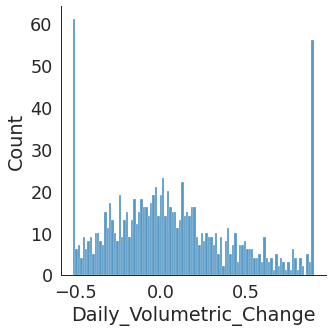

In [28]:
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
vol_fig = sns.displot(data=data, x="Daily_Volumetric_Change", kind="hist", bins = 100, aspect = 1.0)

In [29]:
DailyVolCh = data["Daily_Volumetric_Change"].values
dist1 = Fitter(DailyVolCh,timeout=1000, distributions = ['vonmises_line'])
dist1.fit()

Fitting 1 distributions: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
vonmises_line,35.388407,82.427092,-3499.352641,inf,0.185278,9.393322e-32


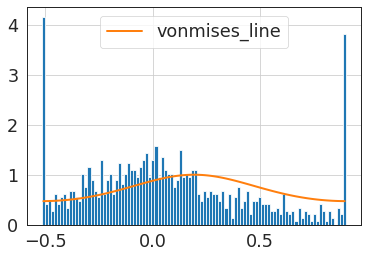

In [30]:
dist1.summary()

In [31]:
from scipy.stats import vonmises_line
trns1 = dist1.get_best()
#trns1 = flatten_dict(trns1)
kappa, loc, scale = trns1['vonmises_line']['kappa'], trns1['vonmises_line']['loc'], trns1['vonmises_line']['scale']
data['transVol'] = vonmises_line.cdf(DailyVolCh, kappa, loc = loc, scale = scale)

In [32]:
trns1 = dist1.get_best()
trns1

{'vonmises_line': {'kappa': 0.37820575291658665,
  'loc': 0.1922914659277885,
  'scale': 0.22510534267953708}}

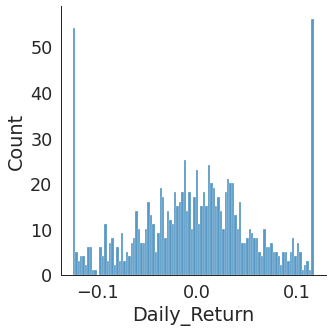

In [33]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
Daily_Return_fig = sns.displot(data=data, x="Daily_Return", kind="hist", bins = 100, aspect = 1.0)

In [34]:
from scipy.stats import skewcauchy
DailyReturn = data["Daily_Return"].values
dist2 = Fitter(DailyVolCh,timeout=1000, distributions = ['skewcauchy'])
dist2.fit()

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


In [35]:
trns2 = dist2.get_best()
shape, loc, scale = trns2['skewcauchy']['a'], trns2['skewcauchy']['loc'], trns2['skewcauchy']['scale']
data['transDR'] = skewcauchy.cdf(DailyVolCh, shape, loc = loc, scale = scale)

In [36]:
from sklearn.model_selection import train_test_split
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.normal(size=[self.input_size, self.hidden_size])
        self.bias = np.random.normal(size=[1, self.hidden_size])
        self.output_weights = None
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def fit(self, X, y):
        # Calculate the hidden layer output
        G = self.relu(np.dot(X, self.input_weights) + self.bias)
        
        # Calculate the output weights using the Moore-Penrose pseudoinverse
        self.output_weights = np.dot(np.linalg.pinv(G), y)
    
    def predict(self, X):
        # Calculate the hidden layer output
        G = self.relu(np.dot(X, self.input_weights) + self.bias)
        
        # Calculate the predicted output
        y_pred = np.dot(G, self.output_weights)
        return y_pred

X = np.array(data['transVol']).reshape(-1,1)
y = data['transDR']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2)
elm = ELM(input_size=X.shape[1], hidden_size=10, output_size=1)
results = elm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = elm.predict(X_test)


# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
n = X.shape[0] # number of observations
k = X.shape[1] # number of predictors
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print("RMSE: ",rmse) 
print("R2 Score: ",r_squared) 
print("MAE: ", mae) 
print("Adjusted R-squared: ",adj_r_squared) 

RMSE:  0.031474537696619426
R2 Score:  0.9864340570832535
MAE:  0.02601749697471285
Adjusted R-squared:  0.9864210003528235


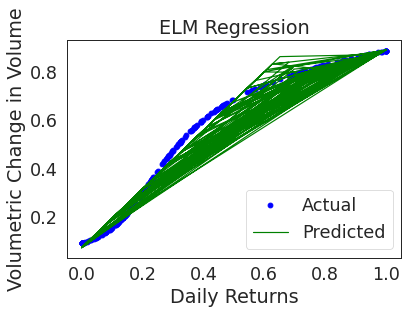

In [37]:
import matplotlib.pyplot as plt

# Plot the predicted and actual values
plt.plot(X_test, y_test, 'bo', label='Actual')
plt.plot(X_test, y_pred, 'g', label='Predicted')
plt.xlabel('Daily Returns')
plt.ylabel('Volumetric Change in Volume')
plt.title('ELM Regression')
plt.legend()
plt.show()

In [38]:
iqr = data.quantile(0.75) - data.quantile(0.25)
print("Descriptive Statistics of the Dataset is given below: ")
stats = pd.concat([data.describe().T,
                data.mad().to_frame('MAD'),
                data.skew().to_frame('Skew'),
                data.kurtosis().to_frame('Kurtosis'),
                data.sem().to_frame('SEM'),
                iqr.to_frame('IQR'),
                data.var().to_frame('Variance')
            ],
              axis=1)
stats.to_excel('sol1.xlsx')

Descriptive Statistics of the Dataset is given below: 
